In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from GalPop import *
from tqdm.notebook import tqdm
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [2]:
cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c_head = cosmos_file[0].header
cosmos_head = cosmos_file[1].header
c20p = cosmos_file[1].data

OSError: [WinError 1455] The paging file is too small for this operation to complete

In [2]:
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)
IRAC_cut = 25.

In [3]:
### PREP ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

sigs = [2.0, 3.0, 4.0]
p_sums = []
for s in sigs:
    p_sums.append(np.genfromtxt(f"HyperionPeaks_new/peaks_sig{s}.dat", dtype=float))


cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

In [49]:
### BUILD SMFs ###
sp_keys = [['field1', 'field2']] + [f'o{s}' for s in sigs] 
smf_keys = ['field'] + [f'o{s}' for s in sigs] 

for idx, t in enumerate(tot_pops):
    # Make SMFs #
    m_range = [9., 11.5, 0.25]
    t.make_SMF(sp_keys, smf_keys ,m_range)

    # Make fits #
    # t.fit_SMF(smf_keys, smf_keys, [1 for s in smf_keys], p0=[10, 1, -1], maxfev=3000)
    
    # t.SMF_plot(smf_keys, smf_keys, smf_keys, smf_keys, title="", plot="None")

In [50]:
def schechter(M, phi_star, alpha, m_star):
  return np.log(10)*phi_star*10**((M-m_star)*(1+alpha))*np.exp(-10**(M-m_star))

In [51]:
def Dschechter(M, M_star, phi_s1, phi_s2, alpha_1, alpha_2):
    return np.log(10)*np.exp(-10**(M-M_star))*(phi_s1*(10**(M-M_star))**(alpha_1+1) \
    +phi_s2*(10**(M-M_star))**(alpha_2+1) )

In [52]:
def C20field(m, fn):
    if fn == 0:
        return Dschechter(m, 10.78,0.27e-3, 0.27e-3, -1.46, 0.07 )
    else:
        return schechter(m, 0.24e-3, -1.46, 10.97)

In [53]:
tot_pops[0].vols

{'field1': 1089069.1031565026,
 'field2': 1089759.9021578806,
 'o2.0': 139541.553,
 'o3.0': 25398.113999999998,
 'o4.0': 6000.375}

In [54]:
tp = tot_pops[0]

len(np.where((tp.n_sigmas >= 2) & (tp.coords[:,2] >2.45) & (tp.coords[:,2] <2.55))[0])

436

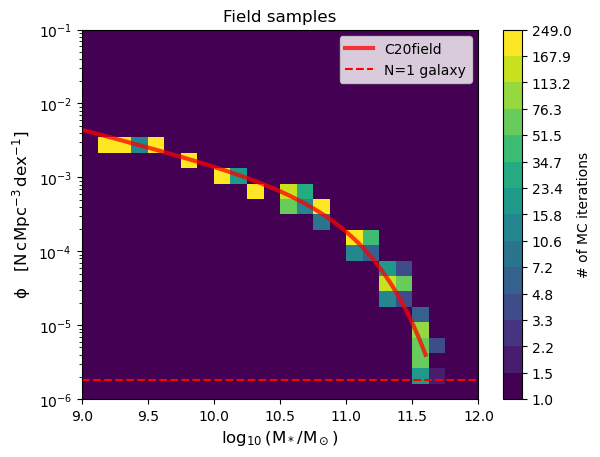

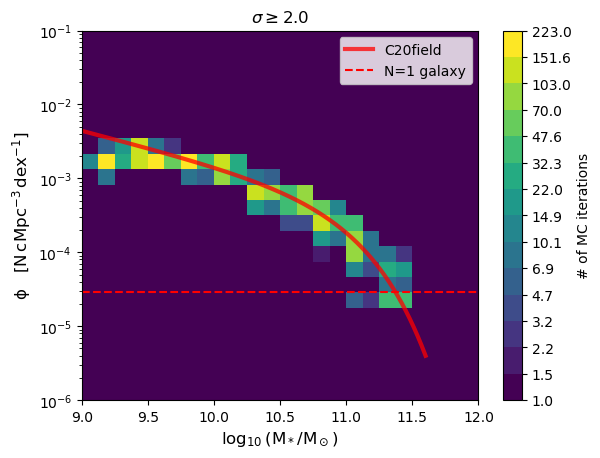

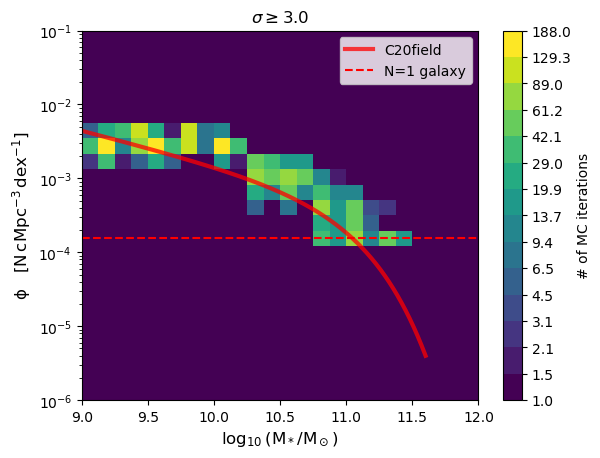

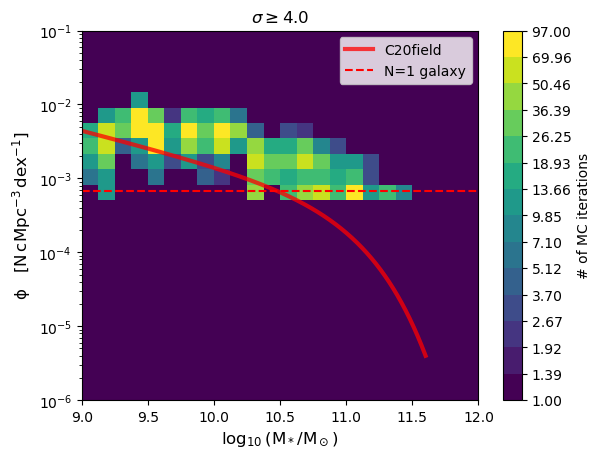

In [55]:
titles = ["Field samples", r"$\sigma \geq 2.0$", r"$\sigma \geq 3.0$", r"$\sigma \geq 4.0$"]
for ki, key in enumerate(smf_keys):
    tot_ms  = []
    tot_ns = []
    n_gal_counts = [0, 0, 0]
    vols = []
    for idx, t in enumerate(tot_pops):

        # for mi, m_cut in enumerate([10.5, 11.0, 11.5]):
        #     n_temp = 0
        #     if ki != 0:

        #         n_gal_counts[mi] += len(np.where(
        #             ( t.ms >= m_cut) & np.in1d(np.arange(len(t.IDs)), t.subpops[key])
        #                 )[0])
        #     else:
        #         n_gal_counts[mi] += len(np.where(
        #             ( t.ms >= m_cut) & (np.in1d(np.arange(len(t.IDs)), t.subpops['field1']) | np.in1d(np.arange(len(t.IDs)), t.subpops['field2']))
        #                 )[0])

        

        if ki ==0:  # field
            vols.append(t.vols['field1'] + t.vols['field2'])
        else: vols.append(t.vols[key])
        tot_ms  = np.concatenate((tot_ms, t.smfs[key][:,0]), axis=0)
        tot_ns = np.concatenate((tot_ns, t.smfs[key][:,2]), axis=0)

    xbin = np.linspace(9, 12, 25)
    ybin = np.logspace(-6, -1, 25)


    fig, ax = plt.subplots()
    ms = np.linspace(9, 11.6, 1000)
    if ki >= 0:
        ax.plot(ms, C20field(ms, 1), color='red', lw='3', alpha=0.75, label="C20field")

    # Create a 2D histogram
    hist, xedges, yedges, im = ax.hist2d(tot_ms, tot_ns, bins=(xbin, ybin), norm=LogNorm())

    # Define the number of discrete levels
    log_min = np.log10(hist[hist > 0].min())
    log_max = np.log10(hist.max())
    levels = np.logspace(log_min, log_max, num=15)

    # Use a BoundaryNorm to create discrete color levels
    norm = BoundaryNorm(levels, ncolors=plt.get_cmap('viridis').N, clip=True)

    # Plot the 2D histogram again with the discrete norm
    h = ax.hist2d(tot_ms, tot_ns, bins=(xbin, ybin), norm=norm, cmap='viridis')
    fig.colorbar(h[3], ax=ax, ticks=levels, label="# of MC iterations")
 
    ax.set(yscale='log', ylim=(1e-6, 1e-1), title=titles[ki])
    ax.set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=12)
    ax.set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=12)
    ax.hlines(y=1/np.mean(vols)/0.25, xmin=9, xmax=12, color='r', ls='dashed', label="N=1 galaxy")

    ax.legend(loc="upper right")
    # bbox = dict(boxstyle='round', fc = "white", ec='white', alpha=0.5)
    # ax.text(0.05, 0.4, f"# of Galaxies (M$\geq$ 10.5) \n= {n_gal_counts[0]}", fontsize=7,
    #                     bbox=bbox,transform=ax.transAxes)
    # ax.text(0.05, 0.3, f"# of Galaxies (M$\geq$ 11.0) \n= {n_gal_counts[1]}", fontsize=7,
    #                     bbox=bbox,transform=ax.transAxes)
    # ax.text(0.05, 0.2, f"# of Galaxies (M$\geq$ 11.5) \n= {n_gal_counts[2]}", fontsize=7,
    #                     bbox=bbox,transform=ax.transAxes)
    plt.show()

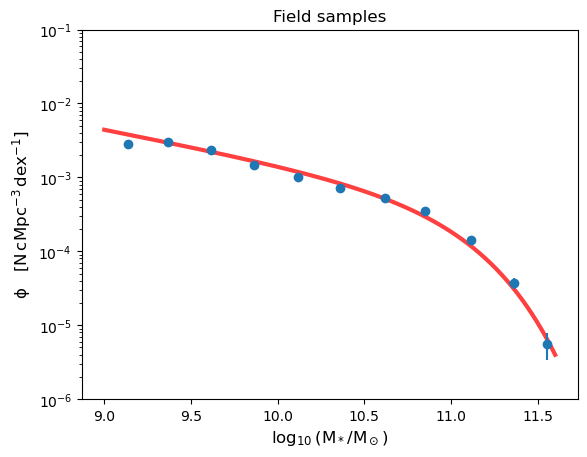

c:\Users\sikor\Anaconda3\envs\py38\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


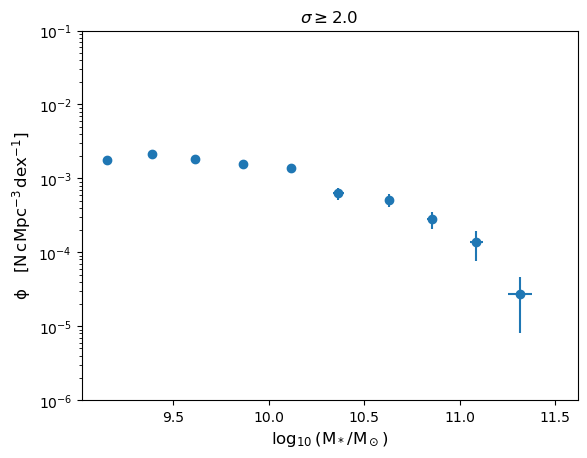

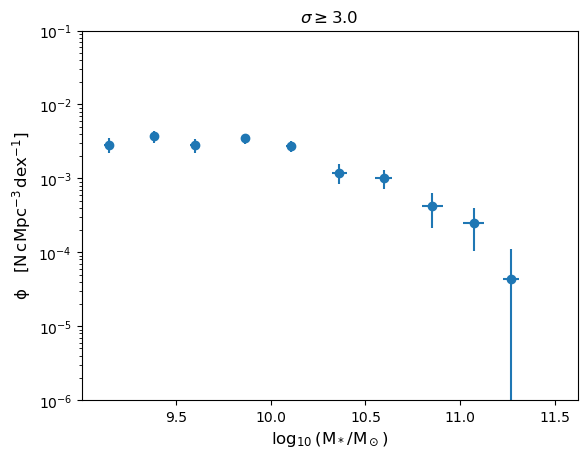

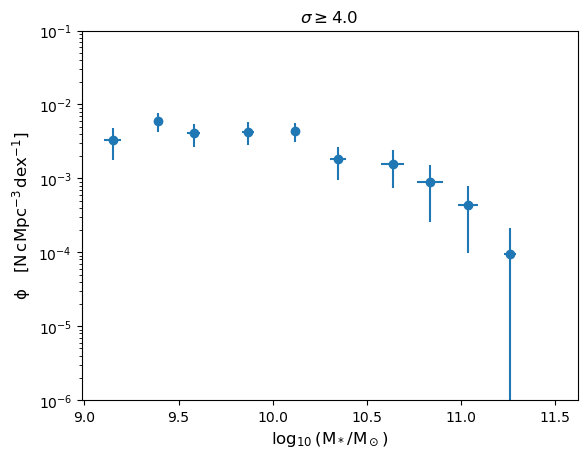

In [ ]:
titles = ["Field samples", r"$\sigma \geq 2.0$", r"$\sigma \geq 3.0$", r"$\sigma \geq 4.0$"]
for ki, key in enumerate(smf_keys):
    tot_ms  = np.zeros(shape=(len(tot_pops), len(tot_pops[0].smfs['field'])))
    tot_ns = np.zeros(shape=(len(tot_pops), len(tot_pops[0].smfs['field'])))

    for idx, t in enumerate(tot_pops):


        tot_ms[idx]  = t.smfs[key][:,0]
        tot_ns[idx] = t.smfs[key][:,2]


    plot_m = []
    plot_n = []
    yerror = []
    xerror = []
    for i in range(len(tot_pops[0].smfs['field'])):
        plot_m.append(np.nansum(tot_ms[:,i])/ len(tot_ms))
        xerror.append(np.std(tot_ms[:,i]))
        plot_n.append(np.nansum(tot_ns[:,i])/len(tot_ns))
        yerror.append(np.nanstd(tot_ns[:,i]))


    xbin = np.linspace(9, 12, 25)
    ybin = np.logspace(-6, -1, 25)

    fig, ax = plt.subplots()
    ms = np.linspace(9, 11.6, 1000)
    if ki == 0:
        ax.plot(ms, C20field(ms, 1), color='red', lw='3', alpha=0.75)

    ax.errorbar(plot_m, plot_n,yerr=yerror, xerr=xerror, marker='o', ls="")
    # Plot the 2D histogram again with the discrete norm 
    ax.set(yscale='log', ylim=(1e-6, 1e-1), title=titles[ki])
    ax.set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=12)
    ax.set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=12)
    plt.show()

---
---
---
---
---
